# Live streaming dei Tweets
In questo notebook vedremo come eseguire il live stream e l'analisi di tweets pubblicati su Twitter in tempo reale usando Spark Streaming. Per accedere ai tweets abbiamo bisogno di un'account sviluppatore Twitter, andiamo [qui](https://developer.twitter.com/) per crearne uno. Dopo averlo fatto crea una app per ottenere le seguenti credenziali:
* Consumer Key
* Consumer Secret
* Access Token
* Accesso Token Secret


Incollale all'interno del file *tweets_stream.py*, ci servirà per prendere i tweets ed inviarli tramite socket TCP a Spark Streaming, all'per evitare di essere inondanti di tweets filtreremo solo quelli legati ad un argomento.

## Inizializziamo Spark
Creiamo i contesti per Spark e Streaming.

In [1]:
from pyspark import SparkContext
from pyspark.streaming import StreamingContext

sc = SparkContext()
ssc = StreamingContext(sc, 5)

e creiamo il DStream che starà in ascolto sulla porta 9999.

In [2]:
lines = ssc.socketTextStream("localhost", 9999)

## Stampiamo gli hashtags in tempo reale
Per prima cosa proviamo a stampare gli hashtag dei tweets in tempo reale, per farlo ci basta dividere i tweets in liste di parole e tenere solo quelle che iniziano per #.

In [3]:
lines.flatMap(lambda text: text.split()) \
  .filter(lambda word: word.lower().startswith("#")) \
  .pprint()

Avviamo il file *tweets_stream.py* da terminale, con il comando:
<br><br>
**python3 tweets_stream.py**
<br><br>
Ti verrà chiesto quale argomento vuoi monitorare, scegline uno abbastanza discusso (nel bene o nel male), io ad esempio ho inserito Salvini. Ora avviamo lo Streaming e mettiamoci in ascolto.

In [4]:
ssc.start()
ssc.awaitTermination()

-------------------------------------------
Time: 2019-07-11 11:24:55
-------------------------------------------
#Buzzfeed
#Salvini
#Lega
#Savoini.

-------------------------------------------
Time: 2019-07-11 11:25:00
-------------------------------------------
#Salvini
#Savoini
#buzzfeed
#Russiagate
#lega
#savoini
#salvini
#russia
#putin
#Italia
...

-------------------------------------------
Time: 2019-07-11 11:25:05
-------------------------------------------
#Carola
#Salvini"
#Poutine

-------------------------------------------
Time: 2019-07-11 11:25:10
-------------------------------------------
#BuzzFeed
#buzzfeed.
#LegaRussia
#Casellati
#Salvini?
#TOSCANA
#CLANDESTINI
#COOP
#DISCRIMINAZIONE
#Buzzfeed
...

-------------------------------------------
Time: 2019-07-11 11:25:15
-------------------------------------------
#Salvini
#altotradimento
#SalviniDimettiti
#buzzfeed
#buzzfeed
#Savoini

-------------------------------------------
Time: 2019-07-11 11:25:20
-----------------

KeyboardInterrupt: 

Se hai fatto tutto correttamente Spark si connetterà al nostro socket, sul terminale cominceranno a scorrere i tweets in tempo reale, mentre qui vedrai gli hashstag. Appena siamo soddisfatti stoppiamo lo Streaming.

In [27]:
ssc.stop()
!sudo kill $(sudo lsof -t -i:9999)

## Visualizziamo gli hashtags più popolari
Facciamo un passo in avanti, contiamo quante volte ogni hashatag viene utilizzato, in modo da scoprire quali sono gli hashtag più popolari relativi all'argomento che stiamo monitorando. Reinizializziamo contesti e DStream. 

In [1]:
sc = SparkContext()
ssc = StreamingContext(sc, 5)
lines = ssc.socketTextStream("localhost", 9999)

Definiamo la funzione che ci permetterà di ottenere il contesto per il modulo SQL.

In [1]:
from pyspark.sql import SQLContext

def get_sql_context(spark_context):
    if ('sqlContextSingletonInstance' not in globals()):
        globals()['sqlContextSingletonInstance'] = SQLContext(spark_context)
    return globals()['sqlContextSingletonInstance']

Definiamo la funzione per sommare i contatori.

In [2]:
def aggregate_count(new_values, total_sum):
    return sum(new_values) + (total_sum or 0)

Definiamo una funzione per pulire gli hashtag, cioè per convertirli in minuscolo e rimuovere eventuali segni di punteggiatura

In [3]:
import string

def clean_hashtag(hashtag):
    return "#"+hashtag.lower().translate(str.maketrans('', '', string.punctuation))

Definiamo una funzione per processare gli RDD in cui verrà suddiviso il DStream, la funzione creerà un Dataframe, lo ordinerà in base al contatore e ne stamperà i primi 10 risultati.

In [32]:
from pyspark.sql import Row

def process_rdd(time, rdd):
    print("----------- %s -----------" % str(time))
    if(rdd.count()>0):
        sql_context = get_sql_context(rdd.context)
        row_rdd = rdd.map(lambda w: Row(name=w[0], count=w[1]))
        hashtags_df = sql_context.createDataFrame(row_rdd)
        hashtags_df = hashtags_df.orderBy("count", ascending=False)
        hashtags_df.show(10)

Adesso, come prima filtriamo soltanto gli hashtag, eseguiamo il conteggio utilizzando la solita tecnica e salviamo come stato utilizzando il metodo *.updateStateByKey(func)* alla quale passeremo la funzione *aggregate_count(new_values, total_sum)* che abbiamo appena definito, infine applichiamo la funzione *.process_rdd(time, rdd)* all'intero DStream usando il metodo *.foreachRDD(func)*.

In [33]:
lines.flatMap( lambda text: text.split() ) \
  .filter(lambda word: word.lower().startswith("#")) \
  .map(lambda word: (clean_hashtag(word), 1)) \
  .updateStateByKey(aggregate_count) \
  .foreachRDD(process_rdd)

Avviamo lo script *tweets_stream.py* da terminale, poi avviamo lo Streaming e mettiamoci in ascolto, ricordandoci di impostare la directory di checkpoint per lo stato.

In [34]:
ssc.checkpoint("/home/ubuntu")
ssc.start()
ssc.awaitTermination()

----------- 2019-07-11 11:33:40 -----------
----------- 2019-07-11 11:33:45 -----------
+-----+---------+
|count|     name|
+-----+---------+
|    3|#buzzfeed|
|    2| #savoini|
|    1| #salvini|
+-----+---------+

----------- 2019-07-11 11:33:50 -----------
+-----+---------+
|count|     name|
+-----+---------+
|    4|#buzzfeed|
|    2| #savoini|
|    1|   #irony|
|    1| #salvini|
|    1|   #italy|
+-----+---------+

----------- 2019-07-11 11:33:55 -----------
+-----+---------------+
|count|           name|
+-----+---------------+
|    4|      #buzzfeed|
|    2|       #savoini|
|    1|         #irony|
|    1|        #russia|
|    1|         #italy|
|    1|            #sz|
|    1|       #pdlazio|
|    1|         #putin|
|    1|       #salvini|
|    1|#altotradimento|
+-----+---------------+
only showing top 10 rows

----------- 2019-07-11 11:34:00 -----------
+-----+---------------+
|count|           name|
+-----+---------------+
|    4|      #buzzfeed|
|    3|       #salvini|
|    2| 

KeyboardInterrupt: 

Ad ogni batch il Dataframe verrà ricalcolato e riordinato.

In [51]:
ssc.stop()
!sudo kill $(sudo lsof -t -i:9999)

## Creiamo un grafico interattivo
Per concludere, andiamo a creare un grafico interattivo dentro Jupyter Notebook, che mostrerà gli hashtag più popolari, per farlo ci serviranno 3 moduli python:
* **Pandas**: per l'analisi dati
* **Matplotlib**: per creare grafici e visualizzazioni
* **Seaborn**: per dare stile ai grafici di matplotlib

Se non li hai già installali con pip

In [ ]:
!pip3 install pandas
!pip3 install matplotlib
!pip3 install seaborn

  Using cached https://files.pythonhosted.org/packages/19/74/e50234bc82c553fecdbd566d8650801e3fe2d6d8c8d940638e3d8a7c5522/pandas-0.24.2-cp36-cp36m-manylinux1_x86_64.whl
----------- 2019-07-11 11:36:40 -----------
  Using cached https://files.pythonhosted.org/packages/41/17/c62faccbfbd163c7f57f3844689e3a78bae1f403648a6afb1d0866d87fbb/python_dateutil-2.8.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/3d/73/fe30c2daaaa0713420d0382b16fbb761409f532c56bdcc514bf7b6262bb6/pytz-2019.1-py2.py3-none-any.whl
+-----+------------------+
|count|              name|
+-----+------------------+
|   15|         #buzzfeed|
|   11|          #salvini|
|   10|          #savoini|
|    7|        #casellati|
|    3|       #senatoripd|
|    3|             #lega|
|    2|   #altotradimento|
|    2|           #russia|
|    1|#salvininonmollare|
|    1|            #putin|
+-----+------------------+
only showing top 10 rows

  Using cached https://files.pythonhosted.org/packages/87/2d/e4

Inizializziamo contesti e DStream.

In [4]:
sc = SparkContext()
ssc = StreamingContext(sc, 1)
lines = ssc.socketTextStream("localhost", 9999)

Ridefiniamo la funzione *.process_rdd(time, rdd)*, eliminando qualsiasi output e creando una view partendo dal Dataframe.

In [5]:
from pyspark.sql import Row

def process_rdd(time, rdd):
    if(rdd.count()>0):
        sql_context = get_sql_context(rdd.context)
        row_rdd = rdd.map(lambda w: Row(name=w[0], count=w[1]))
        hashtags_df = sql_context.createDataFrame(row_rdd)
        hashtags_df = hashtags_df.createOrReplaceTempView("Hashtags")

E impostiamo la pipeline di elaborazione sul DStream.

In [6]:
lines.flatMap( lambda text: text.split() ) \
  .filter(lambda word: word.lower().startswith("#")) \
  .map(lambda word: (clean_hashtag(word), 1)) \
  .updateStateByKey(aggregate_count) \
  .foreachRDD(process_rdd)

Avviamo lo script *tweets_stream.py* da terminale, poi avviamo lo Streaming in maniera non bloccante, ricordandoci di impostare la directory di checkpoint per lo stato.

In [7]:
ssc.checkpoint("/home/ubuntu")
ssc.start()

Lanciamo una query sulla view che abbiamo creato possiamo vedere gli hashtag che stiamo raccogliendo.

In [12]:
get_sql_context(sc).sql("SELECT * FROM Hashtags ORDER BY count DESC").show()

+-----+-------------+
|count|         name|
+-----+-------------+
|    7|     #salvini|
|    5|    #buzzfeed|
|    4|     #savoini|
|    4|   #casellati|
|    2|  #senatoripd|
|    2|      #carola|
|    1|  #russiagate|
|    1|      #russia|
|    1|       #rubli|
|    1|          #f…|
|    1|       #buzz…|
|    1|#pettegolezzi|
|    1|   #britishgp|
|    1| #legarublona|
|    1| #ilmanifesto|
|    1|   #inedicola|
|    1|        #lega|
|    1|#ossessionati|
|    1|#ossessionata|
|    1|       #mosc…|
+-----+-------------+
only showing top 20 rows



Lasciamo girare lo streaming in background e passiamo alla creazione del grafico, importiamo i seguenti moduli e funzioni

In [10]:
from time import sleep
from IPython import display
import matplotlib.pyplot as plt
import seaborn as sns

Facciamo un primo tentativo creando un grafico statico, estraiamo il dataframe con i 10 hashtag più popolari, utilizziamo il metodo *.toPandas()* per convertirlo in un Dataframe Pandas e utilizziamo matplotlib e seaborn per creare un grafico a barre orizzontali. 

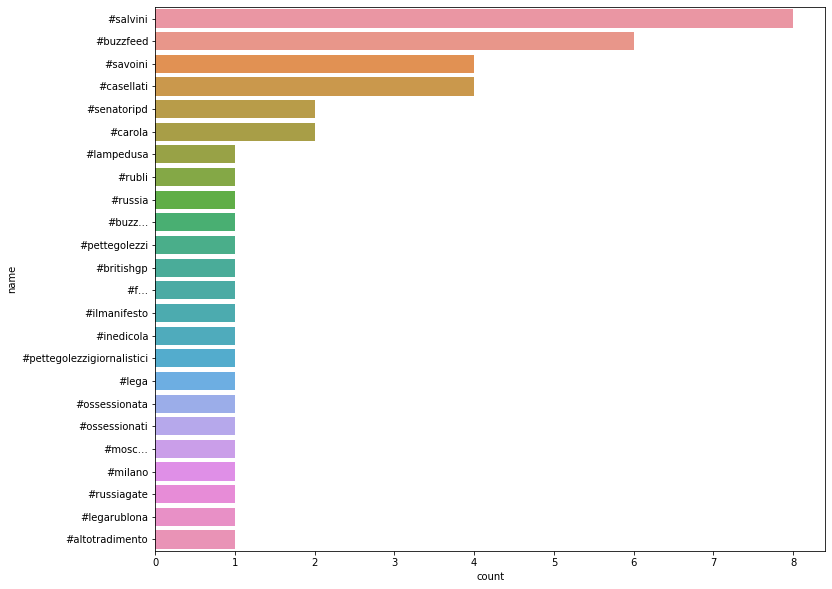

None

In [13]:
df_top = get_sql_context(sc).sql("SELECT * FROM Hashtags ORDER BY count DESC")
df_top_pd = df_top.toPandas()
plt.figure(figsize=(12,10)) # impostiamo la dimensione del grafico
sns.barplot(x="count", y="name", data=df_top_pd) # creiamo il grafico
display.display(plt.show()) # stampiamo il grafico

Ecco qui il nostro grafico ! Ma non ci basta, noi vogliamo che il nostro grafico si aggiorni man mano che arrivano nuovi tweets, dato che il Dataframe si aggiorna automaticamente ci basta inserire il codice di sopra all'interno di un ciclo, utilizzando la funzione *display.clear_output(wait=True)* per cancellare il grafico e la funzione *display.display(plt.show())* per ristamparlo, impostiamo uno sleep di durata pari al tempo di campionamento che abbiamo impostato per Spark Streaming.

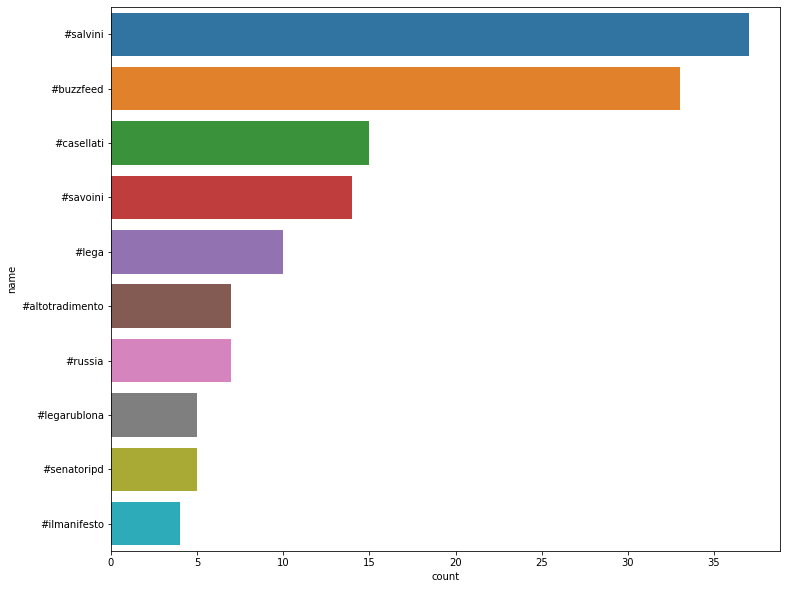

None

KeyboardInterrupt: 

In [14]:
while True:
    display.clear_output(wait=True)
    df_top = get_sql_context(sc).sql("SELECT * FROM hashtags ORDER BY count DESC LIMIT 10")
    df_top_pd = df_top.toPandas()
    plt.figure(figsize=(12,10))
    sns.barplot(x="count", y="name", data=df_top_pd)
    display.display(plt.show())    
    sleep(1)

Et voilà, se hai fatto tutto correttamente vedrai il grafico modificarsi sotto i tuoi occhi :D

In [15]:
ssc.stop()
!sudo kill $(sudo lsof -t -i:9999)

## Link utili e approfondimenti
* [Documentazione di Pandas](https://pandas.pydata.org/pandas-docs/stable/)
* [Documentazione di Matplotlib](https://matplotlib.org/3.1.1/contents.html)
* [Documentazione di Seaborn](https://seaborn.pydata.org/)